In [10]:
import pandas as pd
import numpy as np
import os

class DataPipeline:
    def __init__(self, csv_path, base_path, task_id_column='task_id', task_id=None, unique_threshold=1000, target_column='label', train_frac=0.4, holdout_frac=0.4, random_state=7):
        self.csv_path = csv_path
        self.base_path = base_path
        self.task_id_column = task_id_column
        self.task_id = task_id
        self.unique_threshold = unique_threshold
        self.target_column = target_column
        self.train_frac = train_frac
        self.holdout_frac = holdout_frac
        self.random_state = random_state

        # Load df
        self.df = pd.read_csv(self.csv_path)
        
        if task_id is not None:
            self.df = self.df[self.df[self.task_id_column] == self.task_id]
        if self.df.empty:
            raise ValueError(f"No data found for task_id: {self.task_id}")

    def preprocess_dataframe(self):
        """
        Dropping columns with more than a specified number of unique values and keeping only numerical columns.
        """
        # Drop columns with more than a specified number of unique values
        columns_to_drop = [column for column in self.df.columns if self.df[column].nunique() > self.unique_threshold]
        df_reduced = self.df.drop(columns=columns_to_drop)

        # Keep only numerical columns
        df_clean = df_reduced.select_dtypes(include=[np.number])

        self.df = df_clean

        return df_clean

    def split_data(self):
        """
        Splits the data into training, holdout, and validation sets while preserving label distribution.
        """
        # Separate the dataframe by label
        df_label_0 = self.df[self.df[self.target_column] == 0]
        df_label_1 = self.df[self.df[self.target_column] == 1]

        # Split labeled data
        def split_label_data(df_label):
            total_samples = len(df_label)
            train_size = int(self.train_frac * total_samples)
            holdout_size = int(self.holdout_frac * total_samples)
            validate_size = total_samples - train_size - holdout_size

            df_train = df_label.sample(n=train_size, random_state=self.random_state)
            df_hold = df_label.drop(df_train.index).sample(n=holdout_size, random_state=self.random_state)
            df_val = df_label.drop(df_train.index).drop(df_hold.index)

            return df_train, df_hold, df_val

        df_label_0_train, df_label_0_hold, df_label_0_val = split_label_data(df_label_0)
        df_label_1_train, df_label_1_hold, df_label_1_val = split_label_data(df_label_1)

        # Combine the splits to the final datasets
        df_train = pd.concat([df_label_0_train, df_label_1_train])
        df_holdout = pd.concat([df_label_0_hold, df_label_1_hold])
        df_val = pd.concat([df_label_0_val, df_label_1_val])

        return df_train, df_holdout, df_val, df_label_0_train, df_label_1_train

    def calculate_label_rate(self, df):
        """
        Calculates and prints the label rate in the DataFrame.
        """
        total_samples = len(df)
        label_counts = df[self.target_column].value_counts()
        positive_count = label_counts.get(1, 0)
        negative_count = label_counts.get(0, 0)
        label_rate = positive_count / (positive_count + negative_count) if negative_count != 0 else 0

        print(f"Total Sample size: {total_samples}, Positive Sample size: {positive_count}, Negative Sample size: {negative_count}, label rate: {label_rate:.2f}")

    def shuffle_and_save(self, df_train, df_holdout, df_val, df_label_0_train, df_label_1_train):
        """
        Shuffles and saves the dfs.
        """
        df_train_shuffled = df_train.sample(frac=1).reset_index(drop=True)
        df_holdout_shuffled = df_holdout.sample(frac=1).reset_index(drop=True)
        df_val_shuffled = df_val.sample(frac=1).reset_index(drop=True)

        print("Original set:")
        self.calculate_label_rate(self.df)
        print("Train set:")
        self.calculate_label_rate(df_train_shuffled)
        print("Holdout set:")
        self.calculate_label_rate(df_holdout_shuffled)
        print("Validation set:")
        self.calculate_label_rate(df_val_shuffled)

        os.makedirs(self.base_path, exist_ok=True)

        train_path = os.path.join(self.base_path, f'task_{self.task_id}_train.csv')
        holdout_path = os.path.join(self.base_path, f'task_{self.task_id}_holdout.csv')
        val_path = os.path.join(self.base_path, f'task_{self.task_id}_val.csv')

        df_train_shuffled.to_csv(train_path, index=False)
        df_holdout_shuffled.to_csv(holdout_path, index=False)
        df_val_shuffled.to_csv(val_path, index=False)

        label_0_train_path = os.path.join(self.base_path, f'task_{self.task_id}_label_0_train.csv')
        label_1_train_path = os.path.join(self.base_path, f'task_{self.task_id}_label_1_train.csv')

        df_label_0_train.to_csv(label_0_train_path, index=False)
        df_label_1_train.to_csv(label_1_train_path, index=False)
    

    def run_pipeline(self):
        """
        Executes
        """
        self.preprocess_dataframe()

        split_results = self.split_data()
        df_train, df_holdout, df_val = split_results[:3]
        df_label_0_train,  df_label_1_train = split_results[3:5]

        self.shuffle_and_save(df_train, df_holdout, df_val, df_label_0_train, df_label_1_train)


In [11]:
csv_path = '/Users/chris./Desktop/UCLA_Trustworthy_AI_Lab/24_Summer/Data/train_data_ads.csv'  
base_path = '/Users/chris./Desktop/UCLA_Trustworthy_AI_Lab/24_Summer/Data'     # Replace with the base path to save the processed data
task_id = 10653

pipeline = DataPipeline(csv_path, base_path, task_id=task_id)
pipeline.run_pipeline()

label                 int64
age                   int64
gender                int64
residence             int64
city                  int64
city_rank             int64
series_dev            int64
series_group          int64
emui_dev              int64
device_name           int64
device_size           int64
net_type              int64
task_id               int64
adv_id                int64
creat_type_cd         int64
adv_prim_id           int64
inter_type_cd         int64
slot_id               int64
site_id               int64
spread_app_id         int64
hispace_app_tags      int64
app_second_class      int64
app_score           float64
u_refreshTimes        int64
u_feedLifeCycle       int64
dtype: object
Original set:
Total Sample size: 46242, Positive Sample size: 1528, Negative Sample size: 44714, label rate: 0.03
Train set:
Total Sample size: 18496, Positive Sample size: 611, Negative Sample size: 17885, label rate: 0.03
Holdout set:
Total Sample size: 18496, Positive Sample size: 6

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, roc_auc_score, 
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import os
import seaborn as sns

class EvaluationPipeline:
    def __init__(self, base_path, task_id):
        self.base_path = base_path
        self.task_id = task_id
        self.target_column = 'label'

    def load_data(self):
        """
        Loads dfs.
        """
        train_path = os.path.join(self.base_path, f'task_{self.task_id}_train.csv')
        holdout_path = os.path.join(self.base_path, f'task_{self.task_id}_holdout.csv')
        syn_path0 = os.path.join(self.base_path, f'synthetic_task_{self.task_id}_label_0_train.csv')
        syn_path1 = os.path.join(self.base_path, f'synthetic_task_{self.task_id}_label_1_train.csv')
        val_path = os.path.join(self.base_path, f'task_{self.task_id}_val.csv')

        # Check if all necessary files exist
        if not all(os.path.exists(path) for path in [train_path, holdout_path, syn_path0,syn_path1, val_path]):
            raise FileNotFoundError(f"One or more required datasets are missing for task ID {self.task_id}.")


        self.df_train = pd.read_csv(train_path)
        self.df_holdout = pd.read_csv(holdout_path)
        syn0 = pd.read_csv(syn_path0)
        syn1 = pd.read_csv(syn_path1)
        self.df_syn = pd.concat([syn0,syn1])
        self.df_val = pd.read_csv(val_path)

    def evaluate_and_plot_models(self):
        """
        Evaluates multiple machine learning models on the training, holdout, and synthetic datasets using the validation dataset, and plots ROC and Precision-Recall curves.
        """
        datasets = {
            'Train': self.df_train,
            'Holdout': self.df_holdout,
            'Synthetic': self.df_syn
        }

        models = {
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier(),
            'Gradient Boosting': GradientBoostingClassifier(),
            'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            'DNN': None,  # Placeholder
            'DeepFM': None  # Placeholder
        }

        # Remove models that are None
        models = {name: model for name, model in models.items() if model is not None}

        plt.figure(figsize=(14, 18))
        colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

        results = pd.DataFrame(columns=['Dataset', 'Model', 'Accuracy', 'AUC', 'TPR', 'FPR', 'TNR', 'FNR'])

        for row_index, (dataset_name, df) in enumerate(datasets.items()):
            X_train = df.drop(self.target_column, axis=1)
            y_train = df[self.target_column]
            X_val = self.df_val.drop(self.target_column, axis=1)
            y_val = self.df_val[self.target_column]

            for model_index, (name, model) in enumerate(models.items()):
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                y_proba = model.predict_proba(X_val)[:, 1]  # 獲得正類別的預測概率

                # 計算準確度和AUC
                accuracy = accuracy_score(y_val, y_pred)
                auc = roc_auc_score(y_val, y_proba)

                # 計算混淆矩陣並抽取TP, FN, FP, TN
                tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

                # 計算性能指標
                tpr = tp / (tp + fn)  # 真陽性率
                fpr = fp / (fp + tn)  # 假陽性率
                tnr = tn / (tn + fp)  # 真陰性率
                fnr = fn / (tp + fn)  # 假陰性率

                # Store the metrics in the results DataFrame
                result = pd.DataFrame([{
                    'Dataset': dataset_name,
                    'Model': name,
                    'Accuracy': round(accuracy, 3),
                    'AUC': round(auc, 3),
                    'TPR': round(tpr, 3),
                    'FPR': round(fpr, 3),
                    'TNR': round(tnr, 3),
                    'FNR': round(fnr, 3)
                }])
                results = pd.concat([results, result], ignore_index=True)
                

                # Plot ROC curve
                fpr_values, tpr_values, _ = roc_curve(y_val, y_proba)
                plt.subplot(3, 2, row_index * 2 + 1)
                if model_index == 0:
                    plt.title(f'{dataset_name} - ROC Curve')
                plt.plot(fpr_values, tpr_values, color=colors[model_index % len(colors)], lw=2, label=f'{name} (AUC = {roc_auc_score(y_val, y_proba):.2f})')

                # Plot Precision-Recall curve
                precision, recall, _ = precision_recall_curve(y_val, y_proba)
                plt.subplot(3, 2, row_index * 2 + 2)
                if model_index == 0:
                    plt.title(f'{dataset_name} - Precision-Recall Curve')
                plt.plot(recall, precision, color=colors[model_index % len(colors)], lw=2, label=f'{name} (AP = {average_precision_score(y_val, y_proba):.2f})')

        for i in range(1, 7, 2):
            plt.subplot(3, 2, i)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc="lower right")

        for i in range(2, 8, 2):
            plt.subplot(3, 2, i)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend(loc="upper right")

        plt.tight_layout()
        plt.show()

        self.results = results
    
    def plot_results(self):
        """
        Plots the change in each model's scores for the three datasets.
        """
        metrics = ['Accuracy', 'AUC', 'TPR', 'FPR', 'TNR', 'FNR']
        plt.figure(figsize=(16, 10))
        for i, metric in enumerate(metrics):
            plt.subplot(2, 3, i + 1)
            sns.lineplot(data=self.results, x='Dataset', y=metric, hue='Model', marker='o')
            plt.title(f'Change in {metric} across Datasets')
            plt.ylabel(metric)
            plt.xlabel('Dataset')
            plt.legend(loc='best')
        
        plt.tight_layout()
        plt.show()
    
    def run(self):
        
        self.load_data()
        self.evaluate_and_plot_models()
        self.plot_results()


/var/folders/c7/3m3qgb0159vdypb8y1c07wbw0000gn/T/ipykernel_37362/1126869670.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result], ignore_index=True)


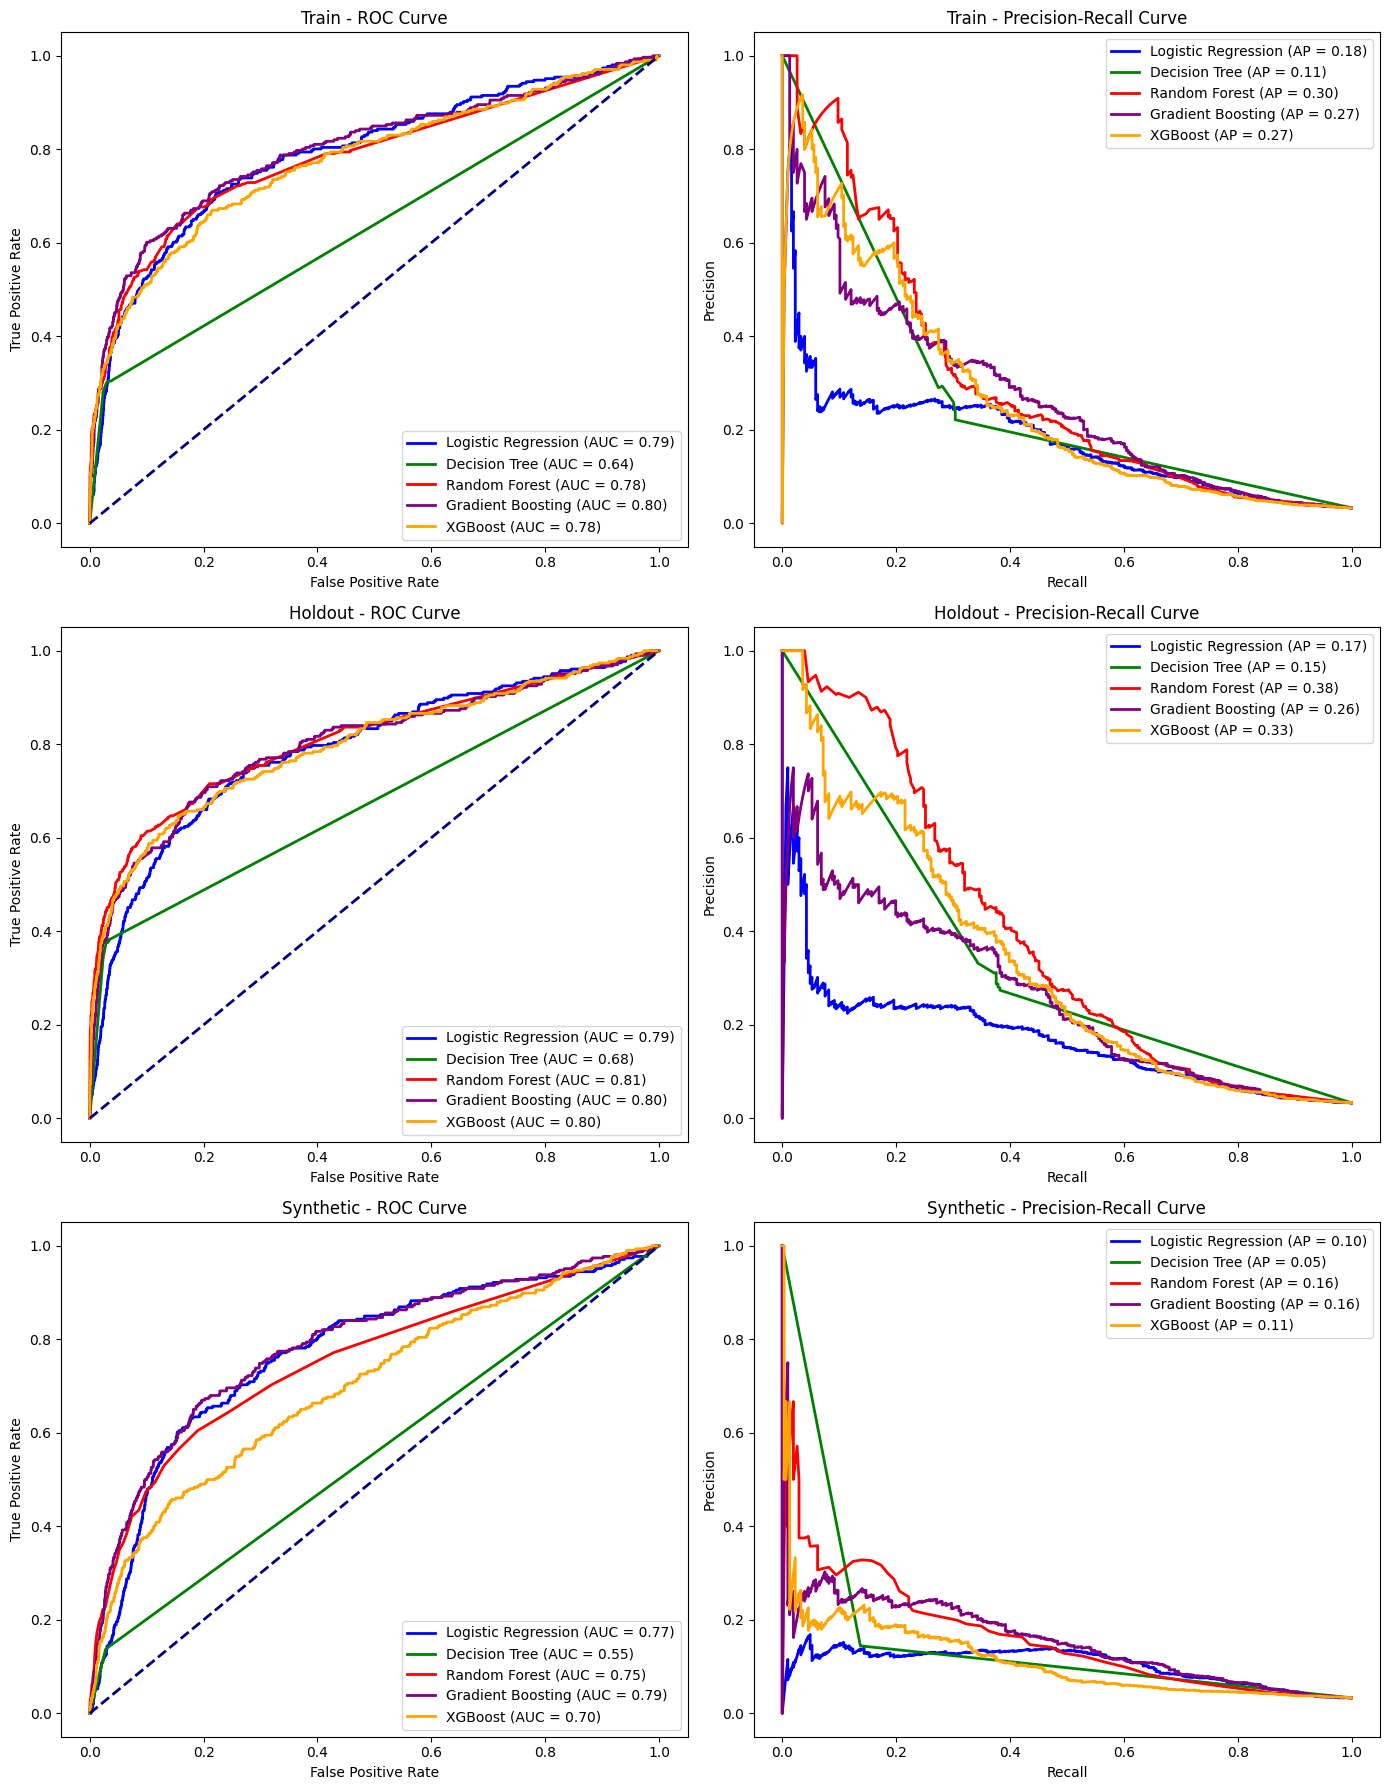

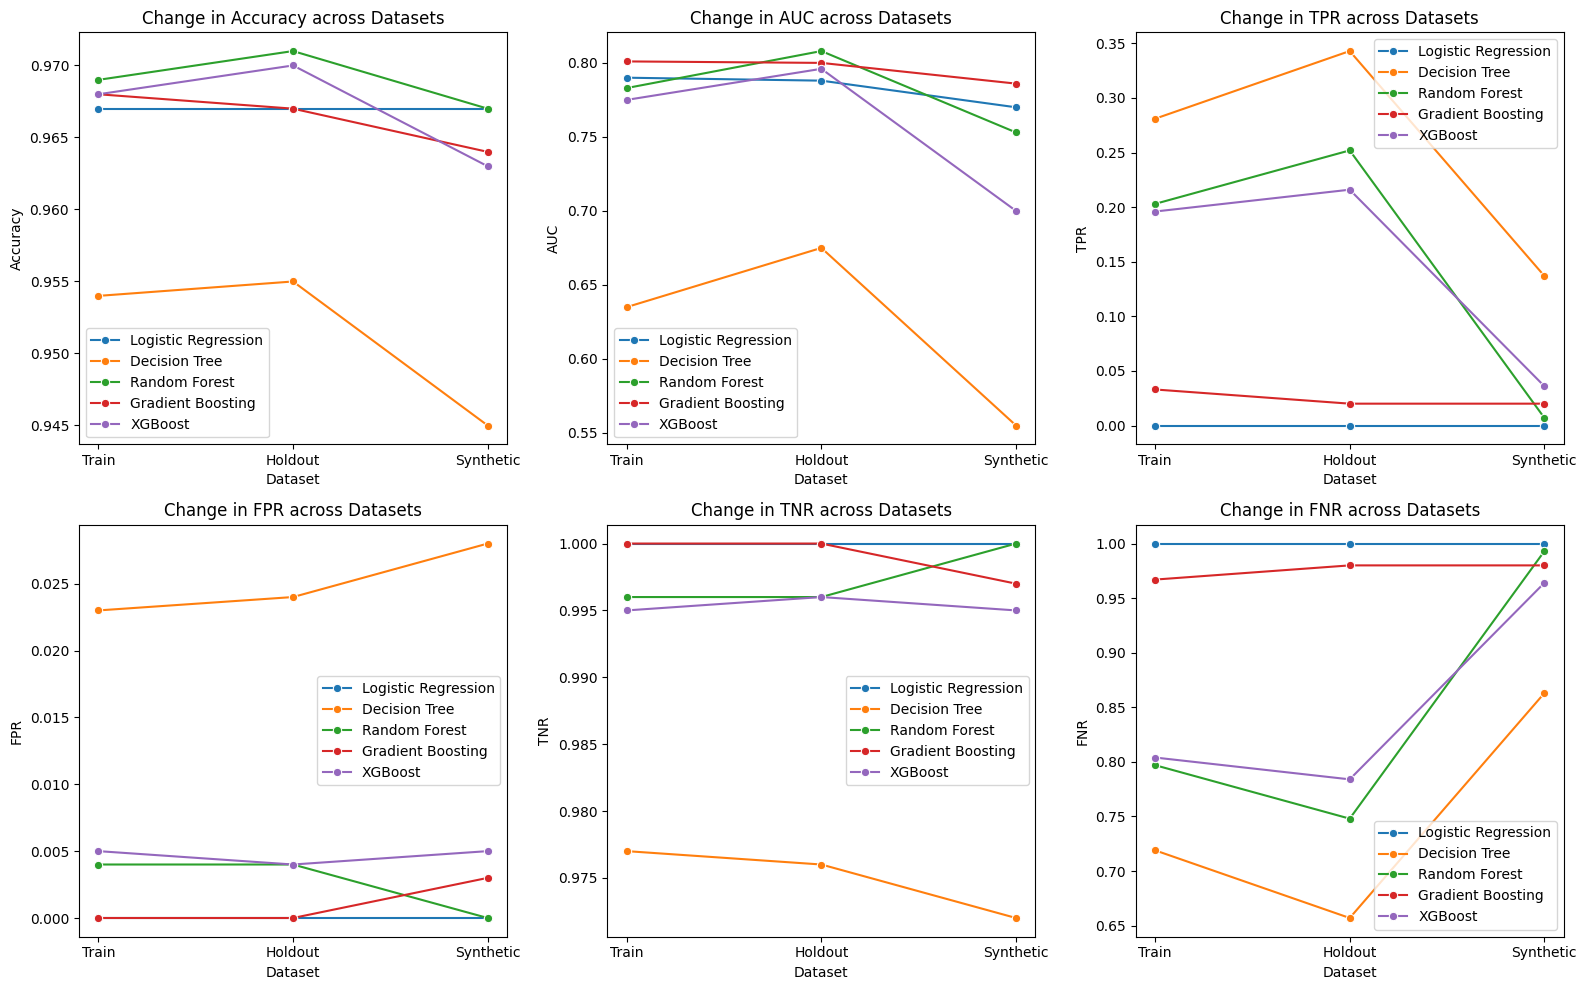

In [38]:

evalpipeline = EvaluationPipeline(base_path, task_id)
evalpipeline.run()

In [39]:
evalpipeline.results

,Dataset,Model,Accuracy,AUC,TPR,FPR,TNR,FNR
0,Train,Logistic Regression,0.967,0.790,0.000,0.000,1.000,1.000
1,Train,Decision Tree,0.954,0.635,0.281,0.023,0.977,0.719
2,Train,Random Forest,0.969,0.783,0.203,0.004,0.996,0.797
3,Train,Gradient Boosting,0.968,0.801,0.033,0.000,1.000,0.967
4,Train,XGBoost,0.968,0.775,0.196,0.005,0.995,0.804
5,Holdout,Logistic Regression,0.967,0.788,0.000,0.000,1.000,1.000
6,Holdout,Decision Tree,0.955,0.675,0.343,0.024,0.976,0.657
7,Holdout,Random Forest,0.971,0.808,0.252,0.004,0.996,0.748
8,Holdout,Gradient Boosting,0.967,0.800,0.020,0.000,1.000,0.980
9,Holdout,XGBoost,0.970,0.796,0.216,0.004,0.996,0.784
